## importing dependencies

In [0]:
import torch
import os, gzip, time, pickle
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Helper functions

In [0]:
# Function for normalize the initial weights
def initialize_weights(net):
  for m in net.modules():
    
    if isinstance(m, nn.Conv2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
      
    elif isinstance(m, nn.ConvTranspose2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
      
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()

In [0]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [0]:
# Utils function for network information printing
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

In [0]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

In [0]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

In [0]:
def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    return scipy.misc.imsave(path, image)

## Preparing data

In [0]:
!rm -r data

In [9]:
import os
os.mkdir('data')
os.mkdir('./data/mnist')

import urllib.request
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'data/mnist/train-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'data/mnist/train-labels-idx1-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 'data/mnist/t10k-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 'data/mnist/t10k-labels-idx1-ubyte.gz')

('data/mnist/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x7f31f1f8a5c0>)

In [0]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)

    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

# Defining the model

## Generator network

In [0]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, dataset = 'mnist'):
        super(generator, self).__init__()
        if dataset == 'mnist' or 'fashion-mnist':
            self.input_height = 28
            self.input_width = 28
            self.input_dim = 62 + 10
            self.output_dim = 1

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)

        return x

## Descriminator network

In [0]:
class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, dataset = 'mnist'):
        super(discriminator, self).__init__()
        if dataset == 'mnist' or 'fashion-mnist':
            self.input_height = 28
            self.input_width = 28
            self.input_dim = 1 + 10
            self.output_dim = 1

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x

## Creating the Generative adverserial network

In [0]:
class GAN(object):
  
  def __init__(self):
    # Parameters
    self.epoch = 25
    self.sample_num = 100
    self.batch_size = 64
    self.save_dir = 'models'
    self.result_dir = 'results'
    self.dataset = 'mnist'
    self.log_dir = 'logs'
    self.gpu_mode = True
    self.model_name = 'GAN'
    self.lrG = 0.0004
    self.lrD = 0.0004
    self.beta1 = 0.5
    self.beta2 = 0.999

    self.G = generator(self.dataset)
    self.D = discriminator(self.dataset)
    self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
    self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))
    
    # load mnist
    self.data_X, self.data_Y = load_mnist(self.dataset)
    self.z_dim = 62
    self.y_dim = 10
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.BCE_loss = nn.BCELoss().cuda()
    else:
      self.BCE_loss = nn.BCELoss()
      
    print('---------- Networks architecture -------------')
    print_network(self.G)
    print_network(self.D)
    print('-----------------------------------------------')
    

    
    # fixed noise & condition
    self.sample_z_ = torch.zeros((self.sample_num, self.z_dim))
    for i in range(10):
        self.sample_z_[i*self.y_dim] = torch.rand(1, self.z_dim)
        for j in range(1, self.y_dim):
            self.sample_z_[i*self.y_dim + j] = self.sample_z_[i*self.y_dim]

    temp = torch.zeros((10, 1))
    for i in range(self.y_dim):
        temp[i, 0] = i

    temp_y = torch.zeros((self.sample_num, 1))
    for i in range(10):
        temp_y[i*self.y_dim: (i+1)*self.y_dim] = temp

    self.sample_y_ = torch.zeros((self.sample_num, self.y_dim))
    self.sample_y_.scatter_(1, temp_y.type(torch.LongTensor), 1)
    if self.gpu_mode:
        self.sample_z_, self.sample_y_ = Variable(self.sample_z_.cuda(), volatile=True), Variable(self.sample_y_.cuda(), volatile=True)
    else:
        self.sample_z_, self.sample_y_ = Variable(self.sample_z_, volatile=True), Variable(self.sample_y_, volatile=True)
        
      
  def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        if self.gpu_mode:
            self.y_real_, self.y_fake_ = Variable(torch.ones(self.batch_size, 1).cuda()), Variable(torch.zeros(self.batch_size, 1).cuda())
        else:
            self.y_real_, self.y_fake_ = Variable(torch.ones(self.batch_size, 1)), Variable(torch.zeros(self.batch_size, 1))

        self.fill = torch.zeros([10, 10, self.data_X.size()[2], self.data_X.size()[3]])
        for i in range(10):
            self.fill[i, i, :, :] = 1

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter in range(len(self.data_X) // self.batch_size):
                x_ = self.data_X[iter*self.batch_size:(iter+1)*self.batch_size]
                z_ = torch.rand((self.batch_size, self.z_dim))
                y_vec_ = self.data_Y[iter*self.batch_size:(iter+1)*self.batch_size]
                y_fill_ = self.fill[torch.max(y_vec_, 1)[1].squeeze()]

                if self.gpu_mode:
                    x_, z_, y_vec_, y_fill_ = Variable(x_.cuda()), Variable(z_.cuda()), \
                                              Variable(y_vec_.cuda()), Variable(y_fill_.cuda())
                else:
                    x_, z_, y_vec_, y_fill_ = Variable(x_), Variable(z_), Variable(y_vec_), Variable(y_fill_)

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_, y_fill_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_, y_vec_)
                D_fake = self.D(G_, y_fill_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.data[0])

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_, y_vec_)
                D_fake = self.D(G_, y_fill_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.data[0])

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), len(self.data_X) // self.batch_size, D_loss.data[0], G_loss.data[0]))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        
        
  def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        image_frame_dim = int(np.floor(np.sqrt(self.sample_num)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_, self.sample_y_)
        else:
            """ random noise """
            temp = torch.LongTensor(self.batch_size, 1).random_() % 10
            sample_y_ = torch.FloatTensor(self.batch_size, 10)
            sample_y_.zero_()
            sample_y_.scatter_(1, temp, 1)
            if self.gpu_mode:
                sample_z_, sample_y_ = Variable(torch.rand((self.batch_size, self.z_dim)).cuda(), volatile=True), \
                                       Variable(sample_y_.cuda(), volatile=True)
            else:
                sample_z_, sample_y_ = Variable(torch.rand((self.batch_size, self.z_dim)), volatile=True), \
                                       Variable(sample_y_, volatile=True)

            samples = self.G(sample_z_, sample_y_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')


  def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

  def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [14]:
g = GAN()
g.train()

---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): ConvTranspose2d (64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Total number of parameters: 6650433
discriminator(
  (conv): Sequential(
    (0): Conv2d (11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(0.2)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2)
  )
  (fc): Sequ

Epoch: [ 4] [ 900/1093] D_loss: 1.34535253, G_loss: 0.76906788
Epoch: [ 4] [1000/1093] D_loss: 1.36522961, G_loss: 0.74431658
Epoch: [ 5] [ 100/1093] D_loss: 1.34297872, G_loss: 0.77895725
Epoch: [ 5] [ 200/1093] D_loss: 1.36389482, G_loss: 0.81426477
Epoch: [ 5] [ 300/1093] D_loss: 1.33629501, G_loss: 0.76783526
Epoch: [ 5] [ 400/1093] D_loss: 1.35454130, G_loss: 0.78035080
Epoch: [ 5] [ 500/1093] D_loss: 1.31901646, G_loss: 0.79861045
Epoch: [ 5] [ 600/1093] D_loss: 1.37348115, G_loss: 0.76309961
Epoch: [ 5] [ 700/1093] D_loss: 1.32165325, G_loss: 0.84069389
Epoch: [ 5] [ 800/1093] D_loss: 1.38411832, G_loss: 0.78946245
Epoch: [ 5] [ 900/1093] D_loss: 1.36049223, G_loss: 0.75909990
Epoch: [ 5] [1000/1093] D_loss: 1.35858452, G_loss: 0.78236413
Epoch: [ 6] [ 100/1093] D_loss: 1.35568547, G_loss: 0.79190910
Epoch: [ 6] [ 200/1093] D_loss: 1.32307434, G_loss: 0.88228297
Epoch: [ 6] [ 300/1093] D_loss: 1.32162738, G_loss: 0.83986694
Epoch: [ 6] [ 400/1093] D_loss: 1.38581979, G_loss: 0.7

Epoch: [10] [ 400/1093] D_loss: 1.20897603, G_loss: 0.93108153
Epoch: [10] [ 500/1093] D_loss: 1.21026754, G_loss: 1.09495711
Epoch: [10] [ 600/1093] D_loss: 1.15728331, G_loss: 1.11634803
Epoch: [10] [ 700/1093] D_loss: 1.06890440, G_loss: 1.08170033
Epoch: [10] [ 800/1093] D_loss: 1.17005706, G_loss: 0.97741139
Epoch: [10] [ 900/1093] D_loss: 1.09192741, G_loss: 1.03252506
Epoch: [10] [1000/1093] D_loss: 1.14482737, G_loss: 0.94454581
Epoch: [11] [ 100/1093] D_loss: 1.20923996, G_loss: 0.97711253
Epoch: [11] [ 200/1093] D_loss: 0.99991190, G_loss: 1.69331121
Epoch: [11] [ 300/1093] D_loss: 1.10067570, G_loss: 1.44683957
Epoch: [11] [ 400/1093] D_loss: 1.11761451, G_loss: 0.99087268
Epoch: [11] [ 500/1093] D_loss: 1.18259168, G_loss: 1.09469104
Epoch: [11] [ 600/1093] D_loss: 1.19724679, G_loss: 0.96976399
Epoch: [11] [ 700/1093] D_loss: 1.04478872, G_loss: 1.13977921
Epoch: [11] [ 800/1093] D_loss: 1.09851146, G_loss: 0.88716042
Epoch: [11] [ 900/1093] D_loss: 1.04818213, G_loss: 1.4

Epoch: [15] [ 900/1093] D_loss: 0.86348987, G_loss: 1.44871485
Epoch: [15] [1000/1093] D_loss: 0.87541437, G_loss: 1.43717289
Epoch: [16] [ 100/1093] D_loss: 1.20539832, G_loss: 0.94673848
Epoch: [16] [ 200/1093] D_loss: 1.03595698, G_loss: 3.72392845
Epoch: [16] [ 300/1093] D_loss: 0.91560042, G_loss: 1.47235441
Epoch: [16] [ 400/1093] D_loss: 0.96895087, G_loss: 1.66934466
Epoch: [16] [ 500/1093] D_loss: 0.84144610, G_loss: 1.48526037
Epoch: [16] [ 600/1093] D_loss: 0.88066345, G_loss: 1.04230118
Epoch: [16] [ 700/1093] D_loss: 0.67198467, G_loss: 1.62930202
Epoch: [16] [ 800/1093] D_loss: 0.78221083, G_loss: 1.60228705
Epoch: [16] [ 900/1093] D_loss: 0.79937816, G_loss: 2.03128529
Epoch: [16] [1000/1093] D_loss: 0.91387320, G_loss: 1.45092523
Epoch: [17] [ 100/1093] D_loss: 1.01312661, G_loss: 1.19059455
Epoch: [17] [ 200/1093] D_loss: 0.83205885, G_loss: 2.20814586
Epoch: [17] [ 300/1093] D_loss: 1.11569118, G_loss: 0.55609751
Epoch: [17] [ 400/1093] D_loss: 0.82966042, G_loss: 1.6

Epoch: [21] [ 400/1093] D_loss: 0.75466752, G_loss: 1.87263131
Epoch: [21] [ 500/1093] D_loss: 0.82800150, G_loss: 1.62340140
Epoch: [21] [ 600/1093] D_loss: 0.56404829, G_loss: 1.89588976
Epoch: [21] [ 700/1093] D_loss: 0.64484394, G_loss: 1.71998096
Epoch: [21] [ 800/1093] D_loss: 0.70309663, G_loss: 1.19792461
Epoch: [21] [ 900/1093] D_loss: 0.78671527, G_loss: 2.17263865
Epoch: [21] [1000/1093] D_loss: 1.05871701, G_loss: 1.96309543
Epoch: [22] [ 100/1093] D_loss: 0.83806008, G_loss: 1.31766391
Epoch: [22] [ 200/1093] D_loss: 1.20041955, G_loss: 4.26096964
Epoch: [22] [ 300/1093] D_loss: 0.71350259, G_loss: 1.32976270
Epoch: [22] [ 400/1093] D_loss: 0.84884036, G_loss: 1.60128522
Epoch: [22] [ 500/1093] D_loss: 0.74488819, G_loss: 1.67390525
Epoch: [22] [ 600/1093] D_loss: 1.04933691, G_loss: 0.77925152
Epoch: [22] [ 700/1093] D_loss: 0.72420216, G_loss: 1.24201703
Epoch: [22] [ 800/1093] D_loss: 0.61963570, G_loss: 1.95691276
Epoch: [22] [ 900/1093] D_loss: 0.56685078, G_loss: 2.3

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


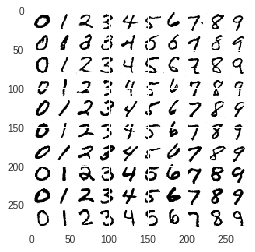

In [15]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results/mnist/GAN/GAN_epoch025.png')
imgplot = plt.imshow(img)
plt.show()